In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split

file_path = "dataR2.csv"
df = pd.read_csv(file_path)

X = df.drop(columns=["Classification"])  
y = df["Classification"]

# (80%) de treino e validaçao / (20%) de teste
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 60% de treino / 20% de validação 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

print(f"Tamanho treino:      {len(X_train)}")
print(f"Tamanho validação:   {len(X_val)}")
print(f"Tamanho teste:       {len(X_test)}")

X_train.to_csv("X_train.csv", index=False)  



Tamanho treino:      69
Tamanho validação:   23
Tamanho teste:       24


In [52]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal

#--------------------------feature selection --------------------------
#Kruskal-Wallis
kruskal_selected_features = []
p_values = {}
classes = np.unique(y_train)
use_lda = X_train.columns
for feature in X_train.columns:
    groups = []
    for have_c in classes:
        groups.append(X_train.loc[y_train == have_c, feature]) #faz uma lista dependendo do valor do classification

    stat, p = kruskal(*groups) #stat fica com o valor H e p fica com o p-value
    p_values[feature] = p
    
    # Selecionar features com diferença estatisticamente significativa  (5% significance level)
    if p < 0.05:
        kruskal_selected_features.append(feature)
        print(f"Feature: {feature}, Kruskal-Wallis H-statistic: {stat}, p-value: {p}")


print("kruskal_selected_features:", kruskal_selected_features)


# Reduzir datasets apenas às features selecionadas pelo Kruskal-Wallis
X_krus_train_sel = X_train[kruskal_selected_features]
X_krus_val_sel = X_val[kruskal_selected_features]
X_krus_test_sel = X_test[kruskal_selected_features]




# ROC-AUC
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc

# --- prepara dados (y_train e X_train já definidos) ---
classes = np.unique(y_train)
pos_label = classes[-1]   # define a classe positiva como a de maior valor (ex: 1 ou 2)

fnames = np.array(X_train.columns)
roc_auc = np.zeros(fnames.shape)

# --- calcular curvas ROC e AUC para cada feature ---
i = 0
for f in fnames:
    x_feat = X_train[f].to_numpy().astype(float)
    y_true = y_train.to_numpy()

    # curva ROC + AUC
    fpr, tpr, _ = roc_curve(y_true, x_feat, pos_label=pos_label)
    a = auc(fpr, tpr)
    if a < 0.5:
        a = 1 - a  # inverter direção se necessário
    roc_auc[i] = a

    # # --- plot -> utilizar este codigo para relatorio  ---
    # figR = go.Figure()
    # figR.add_scatter(x=fpr, y=tpr, mode='lines+markers')
    # figR.update_layout(autosize=False, width=700, height=700, title=dict(text=f))
    # figR.update_xaxes(title_text="1 - Specificidade (FPR)", range=[-0.01, 1.01])
    # figR.update_yaxes(title_text="Sensibilidade (TPR)", range=[-0.01, 1.01])
    # figR.add_annotation(x=0.5, y=0.5, text=f"AUC: {a:.3f}", showarrow=False, yshift=10)
    # figR.show()
    i += 1



# --- selecionar features com AUC acima do limiar (ex: 0.60) ---
roc_auc_selected_features = fnames[roc_auc > 0.60]
print("roc_auc_selected_features:", roc_auc_selected_features)

# --- reduzir os datasets ---
X_auc_train_sel = X_train[roc_auc_selected_features]
X_auc_val_sel   = X_val[roc_auc_selected_features]
X_auc_test_sel  = X_test[roc_auc_selected_features]


# Matriz de Correlação entre todas as features (treino)
import plotly.express as px

X = X_train[kruskal_selected_features].to_numpy().T
corrMat = np.corrcoef(X)
eatures = X_train[kruskal_selected_features].columns.tolist()
fig = px.imshow(
    corrMat,
    text_auto=True,
    labels=dict(x="Features", y="Features", color="Correlação"),
    x=eatures,
    y=eatures,
    width=1000,
    height=1000,
    color_continuous_scale=px.colors.sequential.gray
)
fig.update_layout(title="Matriz de Correlação entre TODAS as Features (Treino)")
fig.show()


Feature: Glucose, Kruskal-Wallis H-statistic: 21.882684786313593, p-value: 2.8983742948778834e-06
Feature: Insulin, Kruskal-Wallis H-statistic: 6.7897432455439075, p-value: 0.009168309393118787
Feature: HOMA, Kruskal-Wallis H-statistic: 10.142517584283269, p-value: 0.0014488814663522185
Feature: Resistin, Kruskal-Wallis H-statistic: 4.873490177055544, p-value: 0.027272288979371395
kruskal_selected_features: ['Glucose', 'Insulin', 'HOMA', 'Resistin']
roc_auc_selected_features: ['Glucose' 'Insulin' 'HOMA' 'Resistin']


In [32]:
#Removemos a insulina pq tem alta correlaçao com a homa mas tem um p-value mais alto 
kruskal_selected_features.remove('Insulin')
print("kruskal_selected_features after removing Insulin:", kruskal_selected_features)


kruskal_selected_features after removing Insulin: ['Glucose', 'HOMA', 'Resistin']



=== Variância Explicada por Componente (PCA) ===
Componente  Eigenvalue (λ)      Var. (%)       Var. Acum. (%)
------------------------------------------------------------
PC1         1.9575              64.3           64.3
PC2         0.8424              27.67          91.98
PC3         0.2442              8.02           100.0

Soma total dos eigenvalues: 3.0441

=== Eigenvectors / Principal Components (Loadings) ===
Feature        PC1         PC2         PC3         
--------------------------------------------------
Glucose        0.663     -0.171    0.7289    
HOMA           0.6259    -0.4077   -0.6649   
Resistin       0.4108    0.897     -0.1632   


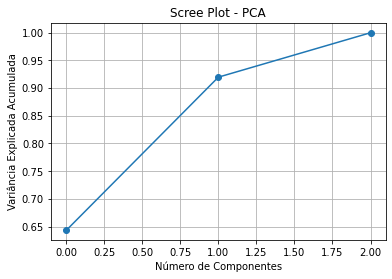

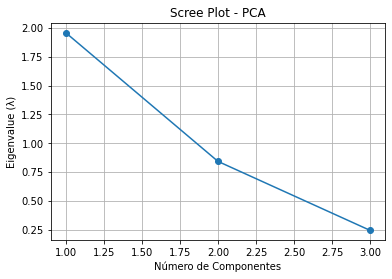

In [33]:
# --------------------dimensionality reduction --------------
X = X_train[kruskal_selected_features].to_numpy()

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Estandardizar (importante no PCA)
X_std = StandardScaler().fit_transform(X)

# Ajustar PCA
pca = PCA()
pca.fit(X_std)

# Variância explicada
eigenvalues = np.round(pca.explained_variance_, 4)
explained_ratio = np.round(pca.explained_variance_ratio_ * 100, 2)
cum_ratio = np.round(np.cumsum(pca.explained_variance_ratio_) * 100, 2)

print("\n=== Variância Explicada por Componente (PCA) ===")
print(f"{'Componente':<12}{'Eigenvalue (λ)':<20}{'Var. (%)':<15}{'Var. Acum. (%)'}")
print("-" * 60)
for i, (eig, var, cum) in enumerate(zip(eigenvalues, explained_ratio, cum_ratio), start=1):
    print(f"PC{i:<10}{eig:<20}{var:<15}{cum}")

# Soma total dos eigenvalues
print(f"\nSoma total dos eigenvalues: {np.sum(eigenvalues):.4f}")

# Componentes principais (autovetores)
components = np.round(pca.components_.T, 4)

print("\n=== Eigenvectors / Principal Components (Loadings) ===")
print(f"{'Feature':<15}" + "".join([f"PC{i+1:<10}" for i in range(components.shape[1])]))
print("-" * 50)
for feat, row in zip(kruskal_selected_features, components):
    vals = "".join([f"{v:<10}" for v in row])
    print(f"{feat:<15}{vals}")

# Scree plot
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Variância Explicada Acumulada")
plt.title("Scree Plot - PCA")
plt.grid(True)
plt.show()


plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
plt.xlabel("Número de Componentes")
plt.ylabel("Eigenvalue (λ)")
plt.title("Scree Plot - PCA")
plt.grid(True)
plt.show()
# depois da observaçao das percentages e do plot chegamos a conclusao que seriam 2, pc1 e pc2, q juntos dao cerca de 92%
n_components_scree = 2

X_pca = pca.transform(X_std)[:, :n_components_scree]

# NÃO sobrescrever `X_train` (DataFrame) — isso causa erros em células seguintes
# Guarde o resultado PCA em variáveis novas. Use `X_train_pca` / `X_train_pca_df` se precisar dos PCs.
X_train_pca = X_pca



In [58]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import plotly.express as px
import pandas as pd

feats = kruskal_selected_features

X = X_train[feats].to_numpy()
y = y_train.to_numpy()
# --- Normalizar ---

X=(X-np.mean(X,axis=0))/np.std(X,axis=0)

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
transformed = lda.transform(X)


#Plot transformed data
fig = px.scatter(x=transformed[:,0], y=np.zeros_like(transformed[:,0]), color=y.astype(str), labels=dict(x="LDA1", y="", color="Class"))
fig.update_traces(marker_size=10)

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import plotly.express as px
import pandas as pd

feats = use_lda

X = X_train[feats].to_numpy()
y = y_train.to_numpy()
# --- Normalizar ---

X=(X-np.mean(X,axis=0))/np.std(X,axis=0)

lda = LinearDiscriminantAnalysis()
lda.fit(X, y)
transformed = lda.transform(X)


#Plot transformed data
fig = px.scatter(x=transformed[:,0], y=np.zeros_like(transformed[:,0]), color=y.astype(str), labels=dict(x="LDA1", y="", color="Class"))
fig.update_traces(marker_size=10)